In [1]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

#those are optional and are not necessary for training
import numpy as np

import matplotlib.pyplot as plt
# We now prepare the training and test data. The dataset includes patients' information along 
# with a 10-year risk of future coronary heart disease (CHD) as a label. The goal is to build
# a model that can predict this 10-year CHD risk based on patients' information.
# random_data() function that generates random, linearly separable points,


In [2]:
torch.random.manual_seed(73)
random.seed(73)


def split_train_test(x, y, test_ratio=0.3):
    idxs = [i for i in range(len(x))]
    random.shuffle(idxs)
    # delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]


def heart_disease_data():
    data = pd.read_csv("./data/framingham.csv")
    # drop rows with missing values
    data = data.dropna()
    # drop some features
    data = data.drop(columns=["education", "currentSmoker", "BPMeds", "diabetes", "diaBP", "BMI"])
    # balance data
    grouped = data.groupby('TenYearCHD')
    data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
    # extract labels
    y = torch.tensor(data["TenYearCHD"].values).float().unsqueeze(1)
    data = data.drop("TenYearCHD", 'columns')
    # standardize data
    data = (data - data.mean()) / data.std()
    x = torch.tensor(data.values).float()
    return split_train_test(x, y)


def random_data(m=1024, n=2):
    # data separable by the line `y = x`
    x_train = torch.randn(m, n)
    x_test = torch.randn(m // 2, n)
    y_train = (x_train[:, 0] >= x_train[:, 1]).float().unsqueeze(0).t()
    y_test = (x_test[:, 0] >= x_test[:, 1]).float().unsqueeze(0).t()
    return x_train, y_train, x_test, y_test


# You can use whatever data you want without modification to the tutorial
# x_train, y_train, x_test, y_test = random_data()
x_train, y_train, x_test, y_test = heart_disease_data()

print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")

############# Data summary #############
x_train has shape: torch.Size([780, 9])
y_train has shape: torch.Size([780, 1])
x_test has shape: torch.Size([334, 9])
y_test has shape: torch.Size([334, 1])
#######################################


In [3]:
# Training a Logistic Regression Model
# start training a logistic regression model (without any encryption) which can be viewed as 
# a single layer neural network with a single node.
# Will use this model as a means of comparison against encrypted training and evaluation

class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out
    

In [4]:
n_features = x_train.shape[1]
model = LR(n_features)
# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=1)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()


In [5]:
#define the number of epochs for both plain and encrypted training
EPOCHS = 5

def train(model,  optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model

model = train(model, optim, criterion, x_train, y_train)


Loss at epoch 1: 0.8504331111907959
Loss at epoch 2: 0.6863380670547485
Loss at epoch 3: 0.6358120441436768
Loss at epoch 4: 0.6193529367446899
Loss at epoch 5: 0.6124345064163208


In [6]:
def accuracy(mode, x, y):
    out = model(x)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()

plain_accuracy = accuracy(model, x_test, y_test)
print(f"Accuarcy on plain test_set: {plain_accuracy}")
    

Accuarcy on plain test_set: 0.703592836856842


In [7]:
# Encrypted Evaluation 
# Evaluating the logistic regression model with plain parameters (optionally encrypted parameters)
# on the encrypted test set. We first create a PyTorch-like LR model that can evaluate encrypted data:

class EncryptedLR:
    def __init__(self, torch_lr):
        #TenSEAL processes lists and not torch tensors,
        # so we take out the parameters from the PyTorch model
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        
    def forward(self, enc_x):
        #We dont need to perform sigmoid as this model
        # will only be used for evaluation, and the label 
        # can be deduced without applying sigmoid
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    ### we can use the functions below to perform 
    ## the evaluation with an encrypted model
    
    def encrypt(self,  context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
eelr = EncryptedLR(model)

 # We now create a TenSEAL Context for specifying the scheme and the parameters we are going
    # to use. Here we choose small and secure parameters that allow us to make a single
    # multiplication. That's enough for evaluating a logistic regression model, however we will
    # see that we need larger parameters when doing training on encrypted data.
    

In [8]:
# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()


In [9]:
# Encrypt the whole set before the evaluation
t_start = time()
enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test]
t_end = time()
print(f"Encryption of the test-set took {int(t_end - t_start)} seconds")

Encryption of the test-set took 0 seconds


In [10]:
# (optional) encrypt the model's parameters
# eelr.encrypt(ctx_eval)


# built the EncryptedLR (Logistic Regression) class,dont compute the sigmoid function on the
# encrypted output of the linear layer, simply because its not needed, and computing sigmoid 
# over encrypted data will increase the computation time and require larger encryption
# parameters. However we will use sigmoid for the encrypted  training part. We now proceed 
# with the evaluation of the encrypted test set and compare the accuracy to the one on the 
# plain test set.

def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time()
    
    correct = 0
    for enc_x, y in zip(enc_x_test, y_test):
        #encrypted evaluation
        enc_out = model(enc_x)
        #plain comparison
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(out - y) < 0.5:
            correct += 1
    t_end = time()
    print(f"Evaluated test set of {len(x_test)} entries in {int(t_end - t_start)} seconds")
    print(f"Accuracy: {correct}/{len(x_test)} = {correct / len(x_test)}")
    return correct / len(x_test)

encrypted_accuracy = encrypted_evaluation(eelr, enc_x_test, y_test)
diff_accuracy = plain_accuracy - encrypted_accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy on the encrypted test-set! The noise was on our side...")



Evaluated test set of 334 entries in 0 seconds
Accuracy: 217/334 = 0.6497005988023952
Difference between plain and encrypted accuracies: 0.05389225482940674


In [ ]:
# Training an Encrypted Logistic Regression Model on Encrypted Data
# In this part, we will redefine a PyTorch-like model that can both forward encrypted data
# as well as backpropagate to update the weights and thus train the encrypted logistic 
# regression model on encrypted data.
# Loss Function



In [16]:
class EncryptedLR:
    
    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        
    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out
    
    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1
        
    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
    
    @staticmethod
    def sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return enc_x.polyval([0.5, 0.197, 0, -0.004])
    
    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()    
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [17]:
# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40,21,21,21,21,21,21,40]
# create TenSEALContext 
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()


In [18]:
t_start = time()
enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
enc_y_train = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")

Encryption of the training_set took 9 seconds


Distribution on plain data: 


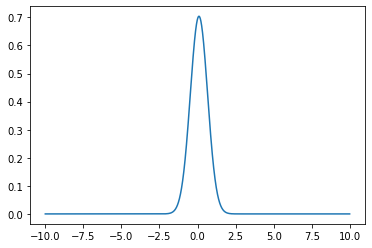

Distribution on encrypted data:


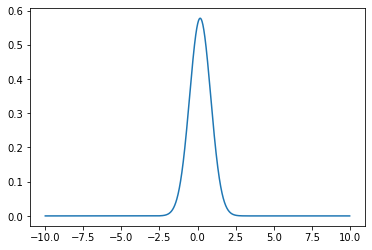

In [19]:
# Since our sigmoid approximation is only good in the range [-5,5], we want to have
# all its inputs in that range. In order to do this, we need to keep our logistic regression
# parameters as well as possible, so we apply regularization.

# Note: Keeping the parameters small certainly reduces the magnitude of the output, but we can
# also get out of range if the data wasn't standardized. We may have spotted that we 
# standardized the data with a mean of 0 and std of 1, this was both for better performance,
# as well as to keep the inputs to the sigmoid in the desired range.

normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin= -10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)

# plain distribution
lr = LR(n_features)
data = lr.lr(x_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data: ")
plt.show()

#encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

eelr = EncryptedLR(lr)
eelr.encrypt(ctx_training)
encrypted_out_distribution(eelr, enc_x_train)

In [20]:
# Training an encrypted logistic regression model on encrypted data! We decrypt the weights 
# and reencrypt them again after every epoch, this is necessary since after updating the 
# the weights at at the end of the epoch, we can no longer use them perform enough 
# multiplications, so we need to get them back to the initial ciphertext level. 
# In a real scenario, this would translate to sending the weight back to the secret-key
# holder for decryption and re-encryption. In that case, it will result in just a few Kilobytes
# communication per epoch.

eelr = EncryptedLR(LR(n_features))
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")

times = []
for epoch in range(EPOCHS):
    eelr.encrypt(ctx_training)
    
    # if you want to keep an eye on the distribution to make sure
    # the function approxiamation is still working fine
    # WARNING: this operation is time consuming
    # encrypted_out_distribution(eelr, enc_x_train)
    
    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)
    
    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")


print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")

Accuracy at epoch #0 is 0.443113774061203
Accuracy at epoch #1 is 0.6706587076187134
Accuracy at epoch #2 is 0.6646706461906433
Accuracy at epoch #3 is 0.6796407103538513
Accuracy at epoch #4 is 0.6856287717819214
Accuracy at epoch #5 is 0.6766467094421387

Average time per epoch: 48 seconds
Final accuracy is 0.6766467094421387
Difference between plain and encrypted accuracies: 0.02694612741470337
